# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [2]:
from pathlib import Path
import os
import random
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt

import utils

# modify to where you store your project data including utils.py
datadir = Path("samples")

### Part I: Randomly Sampled Texture (10 pts)

In [3]:
def quilt_random(sample: np.ndarray, out_size: int, patch_size: int) -> np.ndarray:
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image
    of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    # Initialize the target image
    sample_width, sample_height, color_depth = sample.shape
    target = np.zeros((out_size, out_size, color_depth), dtype=np.uint8)
    tiles = (out_size // patch_size) * patch_size

    for i in range(0, tiles, patch_size):
        for j in range(0, tiles, patch_size):
            patch_i = random.randrange(sample_width - patch_size)
            patch_j = random.randrange(sample_height - patch_size)
            patch = sample[
                patch_i : patch_i + patch_size, patch_j : patch_j + patch_size
            ]
            target[i : i + patch_size, j : j + patch_size] = patch

    return target

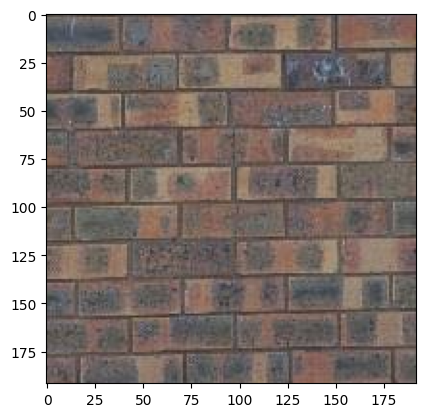

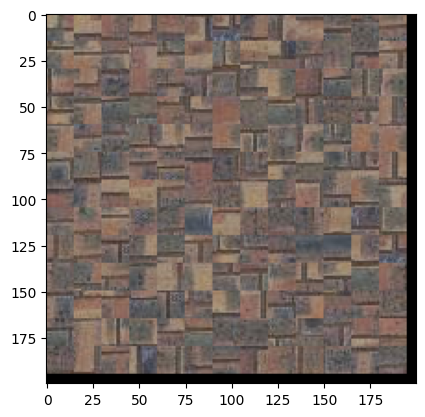

In [4]:
sample_img_fn = "samples/bricks_small.jpg"  # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15
result = quilt_random(sample_img, out_size, patch_size)
if result is not None:
    plt.imshow(result)

### Part II: Overlapping Patches (30 pts)

In [5]:
def ssd_patch(template: np.ndarray, mask: np.ndarray, sample: np.ndarray) -> np.ndarray:
    """
    ssd_patch performs template matching with the overlapping region, computing the cost of sampling
    each patch, based on the sum of squared differences (SSD) of the overlapping regions of the
    existing and sampled patch. I suggest using a masked template. The template is the patch in the
    current output image that is to be filled in (many pixel values will be 0 because they are not
    filled in yet). The mask has the same size as the patch template and has values of 1 in the
    overlapping region and values of 0 elsewhere. The SSD of the masked template with the input
    texture image can be computed efficiently using filtering operations. Suppose I have a template
    T, a mask M, and an image I: then, ssd_cost = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1,
    kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M). You can compute SSD in this way for
    each channel and sum the costs over channels. Each pixel of the ssd_cost gives you the cost for
    sampling a patch centered around that pixel.
    """
    # Dims might be 2 when we use this for luminance
    if sample.ndim == 2:
        sample = sample[:, :, None]
    if template.ndim == 2:
        template = template[:, :, None]
    if mask.ndim == 2:
        mask = mask[:, :, None]
    sample_height, sample_width, sample_channels = sample.shape

    # Broadcast the mask across channels
    mask = np.repeat(mask.astype(np.float32), sample_channels, axis=2)
    template = template.astype(np.float32)
    sample = sample.astype(np.float32)

    # Accumulate SSD over channels
    ssd_image = np.zeros((sample_height, sample_width))

    for channel_index in range(sample_channels):
        template_channel = template[:, :, channel_index]
        sample_channel = sample[:, :, channel_index]
        mask_channel = mask[:, :, channel_index]

        # sum((M * T)^2)
        masked_template_channel = mask_channel * template_channel
        constant_term = np.sum(masked_template_channel**2)

        # Cross term and sample-squared term
        cross_term = cv2.filter2D(
            src=sample_channel,
            ddepth=-1,
            kernel=masked_template_channel,
            borderType=cv2.BORDER_REFLECT,
        )
        sample_squared_term = cv2.filter2D(
            src=sample_channel**2,
            ddepth=-1,
            kernel=mask_channel,
            borderType=cv2.BORDER_REFLECT,
        )

        ssd_image += sample_squared_term - 2.0 * cross_term + constant_term

    # Poison scores on the border to prevent them from ever being selected
    border_size = template.shape[0] // 2
    ssd_image[:border_size] = 1e9
    ssd_image[-border_size:] = 1e9
    ssd_image[:, :border_size] = 1e9
    ssd_image[:, -border_size:] = 1e9

    return ssd_image

In [6]:
def choose_sample(
    sample: np.ndarray, cost_image: np.ndarray, patch_size: int, tolerance: int
) -> np.ndarray:
    """
    choose_sample should take as input a cost image (each pixel's value is the cost of selecting the
    patch centered at that pixel) and select a randomly sampled patch with low cost. It's
    recommended to sort the costs and choose of the tol smallest costs. So if tol=1, the lowest
    cost will always be chosen (this is a good way to debug but mainly copies the input texture). If
    tol=3, one of the three lowest cost patches will be chosen.
    """
    half_patch = patch_size // 2
    # This gets a list of the (flat) indices of the smallest pixels
    top_indices = cost_image.ravel().argpartition(tolerance - 1)[:tolerance]

    flat_index = random.choice(top_indices)
    # Row major order, so convert the single number into y, x coordinates
    y, x = np.unravel_index(flat_index, cost_image.shape)
    y -= half_patch
    x -= half_patch
    y = max(0, min(y, sample.shape[0] - patch_size))
    x = max(0, min(x, sample.shape[1] - patch_size))

    return sample[y : y + patch_size, x : x + patch_size]

In [7]:
def quilt_simple(
    sample: np.ndarray, out_size: int, patch_size: int, overlap: int, tolerance: float
) -> np.ndarray:
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image
    of size outsize.

    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tolerance: float
    :return: numpy.ndarray
    """
    sample_height, sample_width, color_depth = sample.shape
    target = np.zeros((out_size, out_size, color_depth))

    # Convert the sample to float
    sample = sample.copy() / 255.0

    # Create our starter patch:
    patch_i = random.randrange(sample_height - patch_size)
    patch_j = random.randrange(sample_width - patch_size)
    patch = sample[patch_i : patch_i + patch_size, patch_j : patch_j + patch_size]
    target[0:patch_size, 0:patch_size] = patch

    step_size = patch_size - overlap
    tiles = ((out_size - patch_size) // step_size) * step_size

    for i in range(0, tiles, step_size):
        for j in range(0, tiles, step_size):
            if i + j == 0:
                # First row, first column, skip as this is our default
                continue

            template = target[i : i + patch_size, j : j + patch_size]
            mask = np.zeros((patch_size, patch_size, 1), dtype=bool)
            if j != 0:
                # Only apply after the first column
                mask[:, :overlap] = True
            if i != 0:
                # Only apply after the first row
                mask[:overlap] = True

            cost_image = ssd_patch(template=template, mask=mask, sample=sample)
            sample_patch = choose_sample(
                sample=sample,
                cost_image=cost_image,
                patch_size=patch_size,
                tolerance=tolerance,
            )

            # print(i, j, sample.shape)
            target[i : i + patch_size, j : j + patch_size] = sample_patch

    return (target * 255).astype(np.uint8)

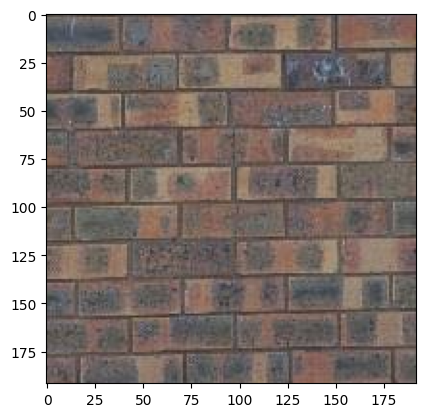

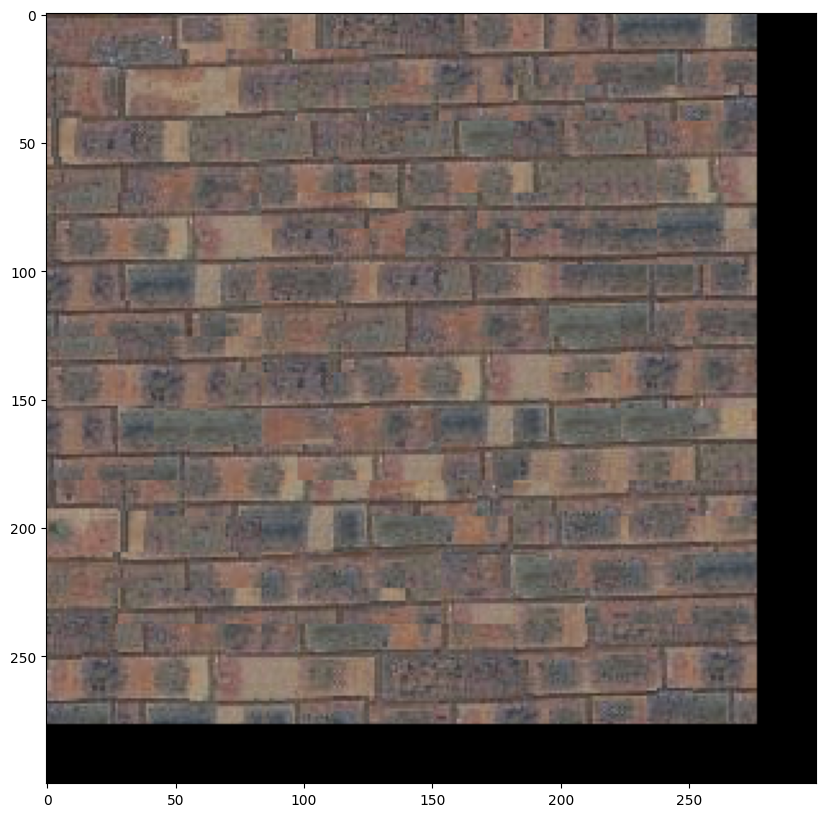

In [8]:
sample_img_fn = "samples/bricks_small.jpg"
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
result = quilt_simple(
    sample_img, out_size, patch_size, overlap, tol
)  # feel free to change parameters to get best results
if result is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(result)

### Part III: Seam Finding (20 pts)


In [9]:
# optional or use cut(err_patch) directly
def customized_cut(
    template: np.ndarray,
    sample_patch: np.ndarray,
    overlap: int,
    use_left_overlap: bool,
    use_top_overlap: bool,
    *,
    debug: bool = False
) -> np.ndarray:
    """
    Seam-cut the overlapping regions between `template` and `sample_patch`.

    For each overlap:
    - Computes an error surface e = (B1 - B2)^2 over the overlap (from SIGGRAPH paper)
    - Uses utils.cut to get the minimal path

    Combines the cut masks and returns the masked combination of template & sample_path

    Returns the blended patch to write into the target image.
    """
    if template.shape != sample_patch.shape:
        raise ValueError("template and sample_patch must have the same shape.")

    patch_height, patch_width, channel_count = sample_patch.shape
    composite_mask = np.ones((patch_height, patch_width), dtype=bool)

    if use_left_overlap:
        # Vertical overlap (left strip of the patch)
        vertical_error = np.sum(
            (template[:, :overlap, :] - sample_patch[:, :overlap, :]) ** 2, axis=2
        )
        # Transpose so we are still cutting left to right
        vertical_cut_overlap_mask = utils.cut(vertical_error.T).astype(bool).T

        # Place into full-size mask.
        composite_mask[:, :overlap] = vertical_cut_overlap_mask

    if use_top_overlap:
        # Horizontal overlap (top strip of the patch)
        horizontal_error = np.sum(
            (template[:overlap, :, :] - sample_patch[:overlap, :, :]) ** 2, axis=2
        )
        horizontal_cut_overlap_mask = utils.cut(horizontal_error).astype(bool)

        # Logical and to combine overlap masks
        composite_mask[:overlap, :] = (
            composite_mask[:overlap, :] & horizontal_cut_overlap_mask
        )

    # Blend using the composite mask
    blended_patch = np.where(composite_mask[..., None], sample_patch, template)

    if not debug:
        return blended_patch

    ## Debug code for displaying intermediate steps ##
    # Overlaps
    if use_left_overlap:
        plt.figure(figsize=(10, 3))
        plt.suptitle("Vertical overlap (left strip)")
        plt.subplot(1, 3, 1)
        plt.title("Template left overlap")
        plt.imshow(np.clip(template[:, :overlap, :], 0.0, 1.0))
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title("Sample left overlap")
        plt.imshow(np.clip(sample_patch[:, :overlap, :], 0.0, 1.0))
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.title("Vertical error (SSD)")
        plt.imshow(vertical_error, cmap="magma")
        plt.axis("off")
        plt.show()

    if use_top_overlap:
        plt.figure(figsize=(10, 3))
        plt.suptitle("Horizontal overlap (top strip)")
        plt.subplot(1, 3, 1)
        plt.title("Template top overlap")
        plt.imshow(np.clip(template[:overlap, :, :], 0.0, 1.0))
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title("Sample top overlap")
        plt.imshow(np.clip(sample_patch[:overlap, :, :], 0.0, 1.0))
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.title("Horizontal error (SSD)")
        plt.imshow(horizontal_error, cmap="magma")
        plt.axis("off")
        plt.show()

    # Masks
    plt.figure(figsize=(12, 3))
    plt.suptitle("Seam masks")
    plt.subplot(1, 3, 1)
    plt.title("Horizontal mask (top)")
    if horizontal_cut_overlap_mask is None:
        plt.imshow(np.zeros((max(1, overlap), patch_width), dtype=float), cmap="gray")
    else:
        plt.imshow(horizontal_cut_overlap_mask.astype(float), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Vertical mask (left)")
    if vertical_cut_overlap_mask is None:
        plt.imshow(np.zeros((patch_height, max(1, overlap)), dtype=float), cmap="gray")
    else:
        plt.imshow(vertical_cut_overlap_mask.astype(float), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Combination mask")
    plt.imshow(composite_mask.astype(float), cmap="gray")
    plt.axis("off")
    plt.show()

    return blended_patch

In [10]:
def quilt_cut(
    sample: np.ndarray, out_size: int, patch_size: int, overlap: int, tolerance: float
) -> np.ndarray:
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an
    output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    sample_height, sample_width, color_depth = sample.shape
    target = np.zeros((out_size, out_size, color_depth))

    # Convert the sample to float
    sample = sample.copy() / 255.0

    # Create our starter patch:
    patch_i = random.randrange(sample_height - patch_size)
    patch_j = random.randrange(sample_width - patch_size)
    patch = sample[patch_i : patch_i + patch_size, patch_j : patch_j + patch_size]
    target[0:patch_size, 0:patch_size] = patch

    step_size = patch_size - overlap
    tiles = ((out_size - patch_size) // step_size) * step_size

    for i in range(0, tiles, step_size):
        for j in range(0, tiles, step_size):
            if i + j == 0:
                # First row, first column, skip as this is our default
                continue

            template = target[i : i + patch_size, j : j + patch_size]
            mask = np.zeros((patch_size, patch_size, 1), dtype=bool)
            if j != 0:
                # Only apply after the first column
                mask[:, :overlap] = True
            if i != 0:
                # Only apply after the first row
                mask[:overlap] = True

            cost_image = ssd_patch(template=template, mask=mask, sample=sample)
            sample_patch = choose_sample(
                sample=sample,
                cost_image=cost_image,
                patch_size=patch_size,
                tolerance=tolerance,
            )

            # Cut and blend the samples
            blended_patch: np.ndarray = customized_cut(
                template=template,
                sample_patch=sample_patch,
                overlap=overlap,
                use_left_overlap=(j != 0),
                use_top_overlap=(i != 0),
            )

            # print(i, j, sample.shape)
            target[i : i + patch_size, j : j + patch_size] = blended_patch

    # For the very last patch, re-do the cutting with debug = True so we can see evidence of the cut
    blended_patch: np.ndarray = customized_cut(
        template=template,
        sample_patch=sample_patch,
        overlap=overlap,
        use_left_overlap=(j != 0),
        use_top_overlap=(i != 0),
        debug=True,
    )

    return (target * 255).astype(np.uint8)

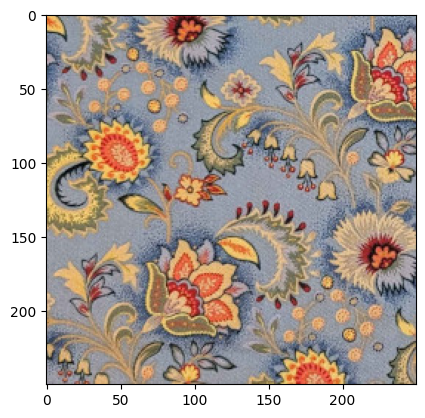

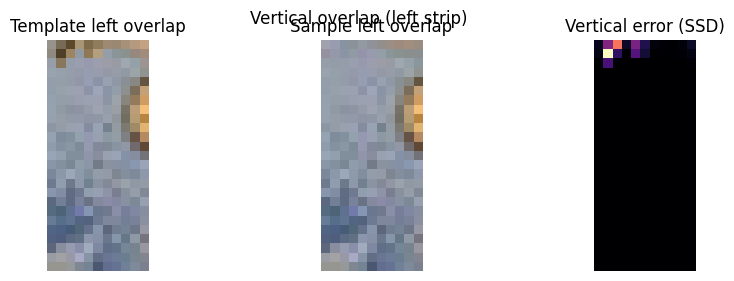

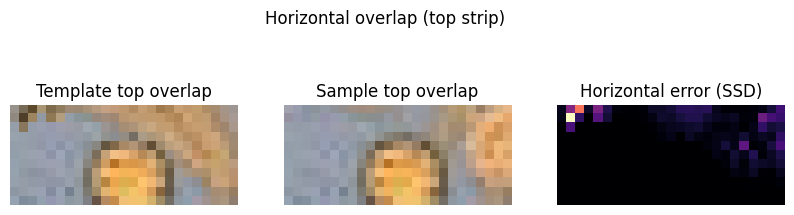

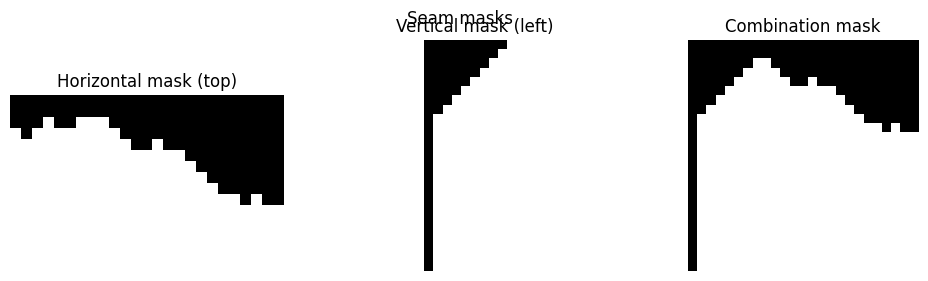

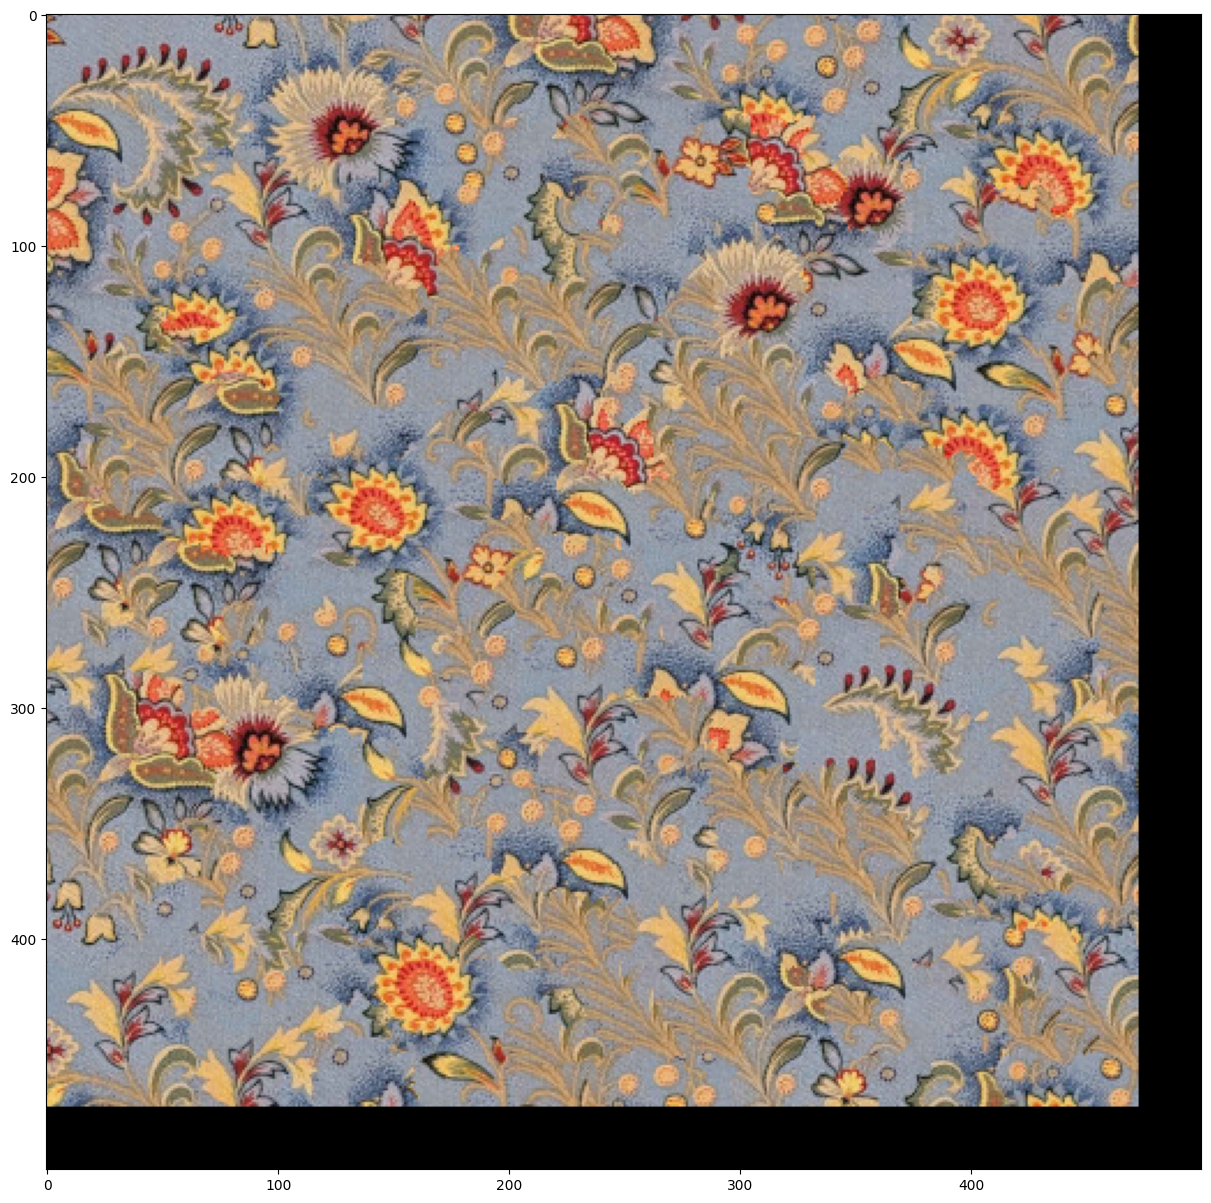

In [11]:
sample_img_fn = "samples/bricks_small.jpg"
sample_img_fn = "my_images/table_cloth_250.jpg"
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 500  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
result = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if result is not None:
    plt.figure(figsize=(15, 15))
    plt.imshow(result)

### part IV: Texture Transfer (30 pts)

In [12]:
def texture_transfer(
    sample: np.ndarray,
    patch_size: int,
    overlap: int,
    tolerance: int,
    guidance_image: np.ndarray,
    alpha: float,
):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an
    output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tolerance: float
    :param guidance_image: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """

    # Luminance
    sample_hls = cv2.cvtColor(sample, cv2.COLOR_RGB2HLS)
    sample_luminance = sample_hls[:, :, 1]
    guidance_hls = cv2.cvtColor(guidance_image, cv2.COLOR_RGB2HLS)
    guidance_luminance = guidance_hls[:, :, 1]

    sample_luminance = sample_luminance / 255.0
    guidance_luminance = guidance_luminance / 255.0

    sample = sample.copy() / 255.0

    output_height, output_width = guidance_luminance.shape
    channel_count = sample.shape[2]
    target = np.zeros((output_height, output_width, channel_count), dtype=np.float32)

    step_size = patch_size - overlap
    last_row = output_height - patch_size
    last_col = output_width - patch_size

    for row in range(0, last_row + 1, step_size):
        for col in range(0, last_col + 1, step_size):
            template = target[row : row + patch_size, col : col + patch_size]

            # Build the overlap mask
            overlap_mask = np.zeros((patch_size, patch_size, 1), dtype=np.float32)
            if col != 0:
                overlap_mask[:, :overlap, 0] = 1.0
            if row != 0:
                overlap_mask[:overlap, :, 0] = 1.0

            # Overlap cost - same as texture synth, above
            if row == 0 and col == 0:
                overlap_cost = np.zeros(sample_luminance.shape, dtype=np.float32)
            else:
                overlap_cost = ssd_patch(
                    template=template,
                    mask=overlap_mask,
                    sample=sample,
                )

            # Guidance cost - SSD again, but between guidance window and sample luminance
            guidance_window = guidance_luminance[
                row : row + patch_size, col : col + patch_size
            ]
            ones_mask = np.ones((patch_size, patch_size, 1), dtype=np.float32)
            guidance_cost = ssd_patch(
                template=guidance_window,
                mask=ones_mask,
                sample=sample_luminance,
            )

            combined_cost = alpha * overlap_cost + (1.0 - alpha) * guidance_cost

            sample_patch = choose_sample(
                sample=sample,
                cost_image=combined_cost,
                patch_size=patch_size,
                tolerance=tolerance,
            )

            sample_patch = customized_cut(
                template=template,
                sample_patch=sample_patch,
                overlap=overlap,
                use_left_overlap=(col != 0),
                use_top_overlap=(row != 0),
                debug=False,
            )

            target[row : row + patch_size, col : col + patch_size] = sample_patch

    return (target * 255).astype(np.uint8)

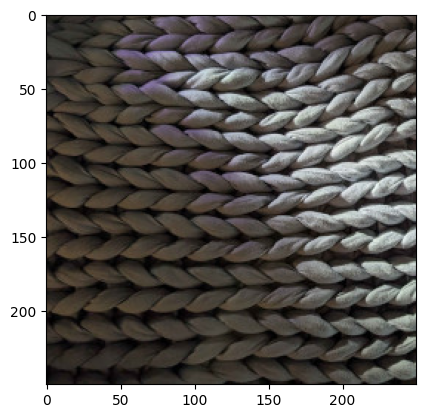

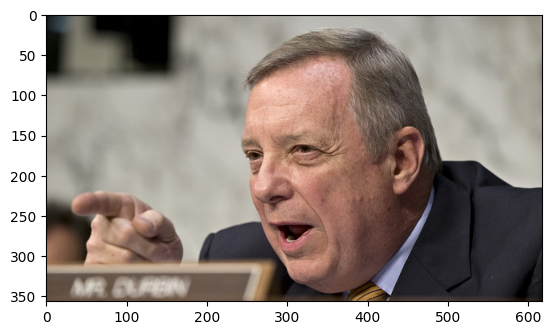

In [ ]:
# load/process appropriate input texture and guidance images
texture_file = "my_images/blanket_250.jpg"
guidance_file = "my_images/illinois_senator_dick_durbin.jpg"
texture_image = cv2.cvtColor(cv2.imread(texture_file), cv2.COLOR_BGR2RGB)
guidance_image = cv2.cvtColor(cv2.imread(guidance_file), cv2.COLOR_BGR2RGB)

plt.imshow(texture_image)
plt.show()
plt.imshow(guidance_image)
plt.show()

patch_size = 15
overlap = 6
tol = 3
alpha = 0.5
result = texture_transfer(
    texture_image, patch_size, overlap, tol, guidance_image, alpha
)

plt.figure(figsize=(15, 15))
plt.imshow(result)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [ ]:
def texture_transfer_iterative(
    sample: np.ndarray,
    patch_size: int,
    overlap: int,
    tolerance: int,
    guidance_image: np.ndarray,
    num_iterations: int = 3,
    shrink_rate: float = 0.666,
) -> np.ndarray:
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an
    output image of size outsize.

    This is largely the same as the texture_transfer function, but it iteratively scales the patch
    size down over num_iterations.

    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tolerance: float
    :param guidance_image: target overall appearance for the output
    :param num_iterations: int (default=3) number of iterations to apply the texture transfer
    :param shrink_rate: float (default=.666) determines the rate the patch size shrinks by
    :return: numpy.ndarray
    """
    # Luminance
    sample_hls = cv2.cvtColor(sample, cv2.COLOR_RGB2HLS)
    sample_luminance = sample_hls[:, :, 1]
    guidance_hls = cv2.cvtColor(guidance_image, cv2.COLOR_RGB2HLS)
    guidance_luminance = guidance_hls[:, :, 1]

    sample_luminance = sample_luminance / 255.0
    guidance_luminance = guidance_luminance / 255.0

    sample = sample.copy() / 255.0

    output_height, output_width = guidance_luminance.shape
    channel_count = sample.shape[2]

    # Relate overlap and patch size so they maintain the same ratio as we scale the patches
    overlap_ratio = overlap / float(patch_size)

    previous_output: np.ndarray = None
    for iteration_index in range(num_iterations):
        # Shrink the patch size each iteration, but never to an even size or below size = 3
        current_patch_size = int(patch_size * (shrink_rate**iteration_index))
        if current_patch_size % 2 == 0:
            current_patch_size = current_patch_size + 1
        if current_patch_size < 3:
            current_patch_size = 3

        current_overlap = int(current_patch_size * overlap_ratio)
        current_overlap = min(current_overlap, current_patch_size - 1)

        # Apply the alpha scaling function from the SIGGRAPH paper
        alpha_i = 0.8 * (iteration_index / ((num_iterations - 1) or 1)) + 0.1

        current_output = np.zeros((output_height, output_width, channel_count))

        step_size = current_patch_size - current_overlap
        last_row = output_height - current_patch_size
        last_col = output_width - current_patch_size

        ones_mask = np.ones((current_patch_size, current_patch_size, 1))

        for row in range(0, last_row + 1, step_size):
            for col in range(0, last_col + 1, step_size):
                # Template: what we have already placed in this iteration at this block.
                template = current_output[
                    row : row + current_patch_size, col : col + current_patch_size
                ]

                # Build the overlap mask
                overlap_mask = np.zeros(
                    (current_patch_size, current_patch_size, 1), dtype=np.float32
                )
                if col != 0:
                    overlap_mask[:, :current_overlap, 0] = 1.0
                if row != 0:
                    overlap_mask[:current_overlap, :, 0] = 1.0

                # Overlap cost - same as texture synth, above
                if row == 0 and col == 0:
                    overlap_cost = np.zeros(sample_luminance.shape)
                else:
                    overlap_cost = ssd_patch(
                        template=template,
                        mask=overlap_mask,
                        sample=sample,
                    )

                # Previous-iteration consistency cost
                if previous_output is None:
                    previous_cost = np.zeros_like(overlap_cost)
                else:
                    previous_window = previous_output[
                        row : row + current_patch_size, col : col + current_patch_size
                    ]
                    previous_cost = ssd_patch(
                        template=previous_window,
                        mask=ones_mask,
                        sample=sample,
                    )

                # Guidance cost - SSD again, but between guidance window and sample luminance
                guidance_window = guidance_luminance[
                    row : row + current_patch_size, col : col + current_patch_size
                ]
                guidance_cost = ssd_patch(
                    template=guidance_window,
                    mask=ones_mask,
                    sample=sample_luminance,
                )

                # Same weighting as texture_transfer but include the previous iteration cost
                local_cost = overlap_cost + previous_cost
                combined_cost = alpha_i * local_cost + (1.0 - alpha_i) * guidance_cost

                # Pick a patch and seam it in
                sample_patch = choose_sample(
                    sample=sample,
                    cost_image=combined_cost,
                    patch_size=current_patch_size,
                    tolerance=tolerance,
                )

                sample_patch = customized_cut(
                    template=template,
                    sample_patch=sample_patch,
                    overlap=current_overlap,
                    use_left_overlap=(col != 0),
                    use_top_overlap=(row != 0),
                    debug=False,
                )

                current_output[
                    row : row + current_patch_size, col : col + current_patch_size
                ] = sample_patch

        # Prepare for next iteration
        previous_output = current_output

    # Final result from the last iteration
    return (previous_output * 255).astype(np.uint8)

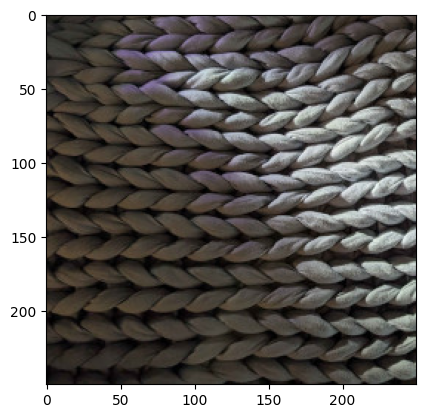

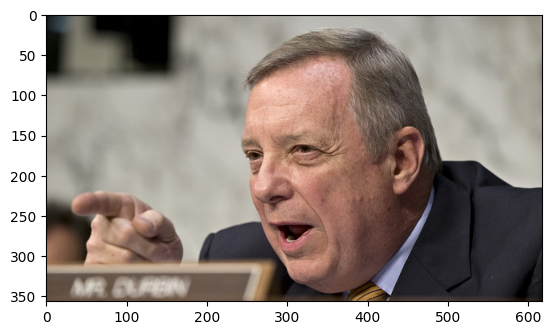

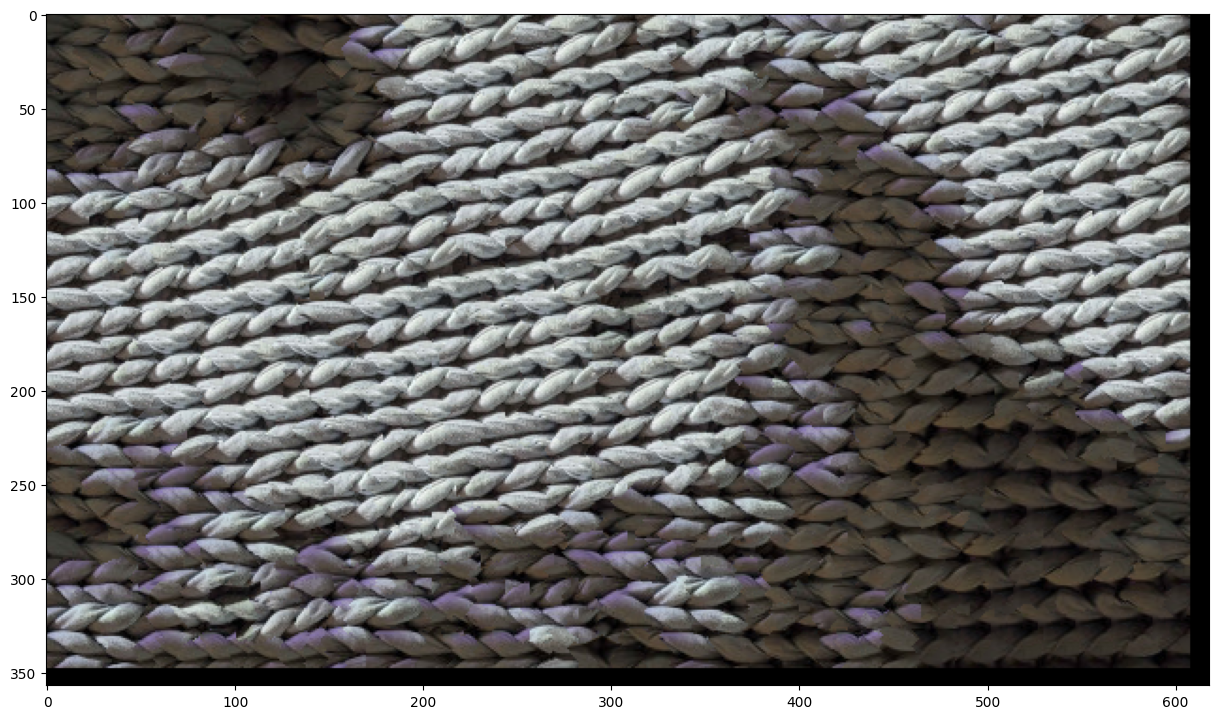

In [ ]:
# load/process appropriate input texture and guidance images
texture_file = "my_images/blanket_250.jpg"
guidance_file = "my_images/illinois_senator_dick_durbin.jpg"
texture_image = cv2.cvtColor(cv2.imread(texture_file), cv2.COLOR_BGR2RGB)
guidance_image = cv2.cvtColor(cv2.imread(guidance_file), cv2.COLOR_BGR2RGB)

plt.imshow(texture_image)
plt.show()
plt.imshow(guidance_image)
plt.show()

patch_size = 50
overlap = 22
tol = 5
alpha = 0.5
result = texture_transfer_iterative(
    texture_image, patch_size, overlap, tol, guidance_image
)

plt.figure(figsize=(15, 15))
plt.imshow(result)
plt.show()

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [ ]:
def embed_image_with_texture_transfer(
    target_image: np.ndarray,
    guidance_image: np.ndarray,
    top_left: tuple[int, int],
    bottom_right: tuple[int, int],
    patch_size: int,
    overlap: int,
    blur_overlap: int,
    tolerance: int,
    num_iterations: int = 3,
    feather_sigma: float = 3.0,
) -> np.ndarray:
    """
    Put one image inside another: synthesize the inner region via texture transfer,
    keep the target border, and blend the seam.

    Parameters
    ----------
    target_image : np.ndarray
        The destination RGB uint8 image that contains the border and defines final size.
    guidance_image : np.ndarray
        Guidance image (RGB uint8) that controls the inner region appearance.
        The inner region will be synthesized to match the luminance of this image.
    patch_size : int
        Patch size for quilting (odd recommended).
    overlap : int
        Overlap width (typically 1/3 to 1/2 of patch_size).
    tolerance : int
        Top-k tolerance for patch center selection.
    num_iterations : int
        Number of iterations for iterative texture transfer (3-5 typical).
    feather_sigma : float
        Sigma (in pixels) for feather blending.

    Returns
    -------
    np.ndarray
        Final composited RGB uint8 image.
    """
    # Pull the internal texture of the image (no edges)
    sample_texture = target_image[
        top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]
    ]

    # Create the inner image
    inner_image = texture_transfer_iterative(
        sample=sample_texture,
        patch_size=patch_size,
        overlap=overlap,
        tolerance=tolerance,
        guidance_image=guidance_image,
        num_iterations=num_iterations,
    )

    # Resize to match the shape of the destination region
    blur_overlap = int(blur_overlap // 2 * 2)
    inner_image = cv2.resize(
        src=inner_image,
        dsize=(
            bottom_right[0] - top_left[0] + blur_overlap,
            bottom_right[1] - top_left[1] + blur_overlap,
        ),
    )

    half_blur = blur_overlap // 2
    inner_image_fullsize = np.zeros(shape=target_image.shape)
    inner_image_fullsize[
        top_left[1] - half_blur : bottom_right[1] + half_blur,
        top_left[0] - half_blur : bottom_right[0] + half_blur,
    ] = inner_image

    # Feather Blend
    # Create a feather blending mask by identifying the inner region and blurring it
    mask = np.zeros(shape=target_image.shape[:2])
    mask[top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]] = 1.0
    kernel_size = 6 * int(feather_sigma) + 1
    soft_mask = cv2.GaussianBlur(
        mask,
        ksize=(kernel_size, kernel_size),
        sigmaX=feather_sigma,
        sigmaY=feather_sigma,
    )
    plt.imshow((soft_mask * 255.0).astype(np.uint8))
    plt.show()
    soft_mask.clip(min=0.0, max=1.0)
    soft_mask = np.repeat(soft_mask.reshape((*soft_mask.shape, 1)), 3, axis=2)

    inner_image_fullsize = inner_image_fullsize.astype(np.float64) / 255.0
    target_image_fullsize = target_image.copy().astype(np.float64) / 255.0

    final_image = inner_image_fullsize * soft_mask + target_image_fullsize * (
        1.0 - soft_mask
    )

    return (final_image * 255.0).astype(np.uint8)

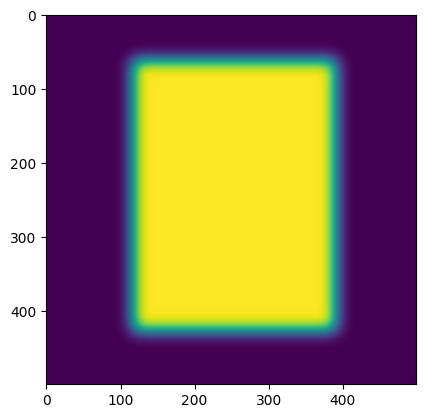

In [ ]:
target_file = "my_images/toast_small.jpg"
guidance_file = "my_images/bezos_small_hc_dnoise.jpg"
target_image = cv2.cvtColor(cv2.imread(target_file), cv2.COLOR_BGR2RGB)
guidance_image = cv2.cvtColor(cv2.imread(guidance_file), cv2.COLOR_BGR2RGB)

final_toast = embed_image_with_texture_transfer(
    target_image=target_image,
    guidance_image=guidance_image,
    top_left=(117, 62),
    bottom_right=(391, 427),
    patch_size=25,
    overlap=11,
    blur_overlap=50,
    tolerance=5,
    num_iterations=3,
    feather_sigma=10.0,
)

In [ ]:
plt.imshow(final_toast)
plt.show()

NameError: name 'plt' is not defined

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).

In [ ]:
def create_hole_mask(
    image_shape: tuple[int, int], polygon_points: np.ndarray
) -> np.ndarray:
    """
    Create a binary hole mask using cv2.fillPoly.
    True = hole (unknown), False = known (source region).
    """
    height, width = image_shape
    hole_mask = np.zeros((height, width), dtype=np.uint8)
    polygon_points_int = np.round(polygon_points).astype(np.int32)[None, ...]
    cv2.fillPoly(hole_mask, polygon_points_int, 255)
    return hole_mask.astype(bool)


def compute_fill_front(hole_mask: np.ndarray) -> np.ndarray:
    """
    Return a boolean mask of the current fill front δΩ as the 1-pixel inward boundary of the hole.
    """
    # Front = hole pixels that have at least one known neighbor.
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(hole_mask.astype(np.uint8), kernel, iterations=1).astype(bool)
    fill_front = hole_mask & (~eroded)
    return fill_front


def compute_normals_from_mask(hole_mask: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Estimate outward normals on the fill front using gradients of a smoothed binary mask.
    Returns (normal_y, normal_x) arrays (float32), same size as mask.
    """
    mask_float = hole_mask.astype(np.float32)
    blurred = cv2.GaussianBlur(mask_float, (0, 0), sigmaX=1.0, sigmaY=1.0)
    grad_x = cv2.Sobel(blurred, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(blurred, cv2.CV_32F, 0, 1, ksize=3)
    magnitude = np.sqrt(grad_x**2 + grad_y**2) + 1e-12
    normal_x = grad_x / magnitude
    normal_y = grad_y / magnitude
    # For a binary hole mask, gradient points from low→high; we want outward from hole.
    # Outward = gradient direction (from hole (1) to known (0)) is negative; flip sign:
    normal_x = -normal_x
    normal_y = -normal_y
    return normal_y, normal_x


def rgb_to_lab_float01(image_rgb_uint8: np.ndarray) -> np.ndarray:
    """
    Convert uint8 RGB to float32 CIE Lab in [0,1]-ish scale for SSD (OpenCV Lab is scaled).
    """
    image_float = image_rgb_uint8.astype(np.float32) / 255.0
    image_lab = cv2.cvtColor(image_float, cv2.COLOR_RGB2Lab)
    return image_lab


def grayscale_for_isophote(image_rgb_uint8: np.ndarray) -> np.ndarray:
    """
    Grayscale for gradient computation. Using L channel from HLS works fine.
    """
    image_float = image_rgb_uint8.astype(np.float32) / 255.0
    image_hls = cv2.cvtColor(image_float, cv2.COLOR_RGB2HLS)
    luminance = image_hls[:, :, 1]
    return luminance


def compute_isophote_vectors(luminance: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute isophote vectors (perpendicular to intensity gradient):
    isophote = (-grad_y, grad_x).
    """
    grad_x = cv2.Sobel(luminance, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(luminance, cv2.CV_32F, 0, 1, ksize=3)
    isophote_x = -grad_y
    isophote_y = grad_x
    return isophote_y, isophote_x


def patch_bounds(
    center_y: int, center_x: int, half_patch: int, height: int, width: int
) -> tuple[int, int, int, int]:
    """
    Compute inclusive-exclusive patch bounds clamped to image.
    """
    y0 = max(0, center_y - half_patch)
    y1 = min(height, center_y + half_patch + 1)
    x0 = max(0, center_x - half_patch)
    x1 = min(width, center_x + half_patch + 1)
    return y0, y1, x0, x1


def average_confidence_in_patch(
    confidence_map: np.ndarray,
    hole_mask: np.ndarray,
    center_y: int,
    center_x: int,
    half_patch: int,
) -> float:
    """
    Confidence term C(p): sum of confidences over known pixels in patch / patch_area.
    """
    height, width = confidence_map.shape
    y0, y1, x0, x1 = patch_bounds(center_y, center_x, half_patch, height, width)
    patch_area = (2 * half_patch + 1) ** 2
    known_region = ~hole_mask[y0:y1, x0:x1]
    confidence_sum = float(confidence_map[y0:y1, x0:x1][known_region].sum())
    return confidence_sum / float(patch_area)


def compute_priority_map(
    confidence_map: np.ndarray,
    hole_mask: np.ndarray,
    fill_front_mask: np.ndarray,
    isophote_y: np.ndarray,
    isophote_x: np.ndarray,
    normal_y: np.ndarray,
    normal_x: np.ndarray,
    patch_size: int,
    alpha_normalization: float = 255.0,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute P(p) = C(p) * D(p) on the fill front. Returns (priority_map, confidence_at_center_map).
    """
    half_patch = patch_size // 2
    height, width = hole_mask.shape

    priority_map = np.zeros_like(hole_mask, dtype=np.float32)
    confidence_at_center = np.zeros_like(hole_mask, dtype=np.float32)

    front_indices = np.argwhere(fill_front_mask)
    for center_y, center_x in front_indices:
        C_p = average_confidence_in_patch(
            confidence_map, hole_mask, center_y, center_x, half_patch
        )
        # Data term: |isophote ⋅ normal| / alpha
        dot = (
            isophote_y[center_y, center_x] * normal_y[center_y, center_x]
            + isophote_x[center_y, center_x] * normal_x[center_y, center_x]
        )
        D_p = abs(dot) / float(alpha_normalization)
        P_p = C_p * D_p
        priority_map[center_y, center_x] = P_p
        confidence_at_center[center_y, center_x] = C_p

    return priority_map, confidence_at_center


def valid_source_centers(known_mask: np.ndarray, patch_size: int) -> np.ndarray:
    """
    Return a boolean map of centers where a full patch lies entirely in known (source) region.
    """
    kernel = np.ones((patch_size, patch_size), dtype=np.uint8)
    # Convolve the known mask count in each patch; fast via cv2.filter2D on uint8.
    known_uint8 = known_mask.astype(np.uint8)
    patch_known_count = cv2.filter2D(
        known_uint8, cv2.CV_32F, kernel, borderType=cv2.BORDER_CONSTANT
    )
    full_count = patch_size * patch_size
    # A center is valid if the whole patch is known.
    valid = patch_known_count == float(full_count)
    return valid.astype(bool)


def best_exemplar_patch(
    image_lab: np.ndarray,
    known_mask: np.ndarray,
    target_center_y: int,
    target_center_x: int,
    patch_size: int,
) -> tuple[np.ndarray, tuple[int, int]]:
    """
    Find the best fully-known source patch (center coordinates) by SSD over known pixels
    of the target patch, then return that patch and its center.
    """
    height, width, channels = image_lab.shape
    half_patch = patch_size // 2

    # Define target patch and its known pixels mask.
    y0_t, y1_t, x0_t, x1_t = patch_bounds(
        target_center_y, target_center_x, half_patch, height, width
    )
    target_patch = image_lab[y0_t:y1_t, x0_t:x1_t, :]
    target_known_mask = known_mask[y0_t:y1_t, x0_t:x1_t]
    if not np.any(target_known_mask):
        # Fallback: if no known pixels inside the patch (degenerate early iteration), enlarge or skip.
        target_known_mask = np.ones_like(target_known_mask, dtype=bool)

    # Precompute valid centers for fully-known source patches.
    source_center_map = valid_source_centers(
        ~(~known_mask), patch_size
    )  # equivalent to known_mask

    best_ssd = np.inf
    best_center = (None, None)

    # Iterate over all valid source centers.
    source_indices = np.argwhere(source_center_map)
    for center_y, center_x in source_indices:
        y0_s, y1_s, x0_s, x1_s = patch_bounds(
            center_y, center_x, half_patch, height, width
        )
        source_patch = image_lab[y0_s:y1_s, x0_s:x1_s, :]
        # Match only on the known pixels of the target patch (broadcast mask across channels).
        mask3 = target_known_mask[..., None]
        diff = (target_patch - source_patch) * mask3
        ssd = float((diff * diff).sum())
        if ssd < best_ssd:
            best_ssd = ssd
            best_center = (center_y, center_x)

    if best_center[0] is None:
        raise RuntimeError("No valid source patch found. Consider reducing patch_size.")

    # Return the actual source patch.
    y0, y1, x0, x1 = patch_bounds(
        best_center[0], best_center[1], half_patch, height, width
    )
    return image_lab[y0:y1, x0:x1, :].copy(), best_center


def copy_into_hole(
    target_image_lab: np.ndarray,
    source_patch_lab: np.ndarray,
    hole_mask: np.ndarray,
    center_y: int,
    center_x: int,
    patch_size: int,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Copy pixels from the source patch into the hole for Ψ_p ∩ Ω.
    Returns updated (image_lab, hole_mask).
    """
    height, width = hole_mask.shape
    half_patch = patch_size // 2
    y0, y1, x0, x1 = patch_bounds(center_y, center_x, half_patch, height, width)
    patch_hole_mask = hole_mask[y0:y1, x0:x1]
    # Copy only where currently unknown (hole).
    for c in range(target_image_lab.shape[2]):
        patch_channel = target_image_lab[y0:y1, x0:x1, c]
        patch_channel[patch_hole_mask] = source_patch_lab[:, :, c][patch_hole_mask]
        target_image_lab[y0:y1, x0:x1, c] = patch_channel
    # Mark those pixels as filled.
    hole_mask[y0:y1, x0:x1][patch_hole_mask] = False
    return target_image_lab, hole_mask


def update_confidence_map(
    confidence_map: np.ndarray,
    hole_mask: np.ndarray,
    center_y: int,
    center_x: int,
    patch_size: int,
    confidence_at_center: float,
) -> np.ndarray:
    """
    Set C(p) = C(p̂) for newly filled pixels in Ψ_p̂ ∩ Ω (per paper).
    """
    height, width = confidence_map.shape
    half_patch = patch_size // 2
    y0, y1, x0, x1 = patch_bounds(center_y, center_x, half_patch, height, width)
    # Newly filled = those that WERE hole before copy; caller should pass pre-copy hole if needed.
    # Here we conservatively set confidence for all pixels of the patch that are not holes.
    # Safer: set where confidence == 0.
    region = confidence_map[y0:y1, x0:x1]
    region[(region == 0.0)] = float(confidence_at_center)
    confidence_map[y0:y1, x0:x1] = region
    return confidence_map


def inpaint_hole_exemplar(
    image_rgb_uint8: np.ndarray,
    polygon_points_clockwise: np.ndarray,
    patch_size: int = 9,
    alpha_normalization: float = 255.0,
    max_iterations: int = 1_000_000,
) -> np.ndarray:
    """
    Exemplar-based hole filling with priority P(p) = C(p) * D(p).
    - image_rgb_uint8: target image (uint8, RGB).
    - polygon_points_clockwise: Nx2 float/int array (x,y) defining the hole boundary in clockwise order.
    - patch_size: odd integer; slightly larger than largest texel/edge thickness in source (per paper).
    - alpha_normalization: 'alpha' in D(p) (255 for typical 8-bit luminance).
    """
    if patch_size % 2 == 0 or patch_size < 3:
        raise ValueError("patch_size must be an odd integer >= 3.")
    height, width, channels = image_rgb_uint8.shape

    # 1) Build hole mask Ω via cv2.fillPoly.
    hole_mask = create_hole_mask((height, width), polygon_points_clockwise)

    # 2) Initialize confidence: 0 in hole, 1 in source (I - Ω).
    confidence_map = (~hole_mask).astype(np.float32)

    # 3) Working images for distance and matching.
    luminance = grayscale_for_isophote(image_rgb_uint8)
    image_lab = rgb_to_lab_float01(image_rgb_uint8)

    half_patch = patch_size // 2
    iteration = 0

    while np.any(hole_mask):
        iteration += 1
        if iteration > max_iterations:
            raise RuntimeError(
                "Exceeded maximum iterations; hole may be ill-posed for this patch size."
            )

        # a) Identify the current fill front δΩ and its normals.
        fill_front = compute_fill_front(hole_mask)
        normal_y, normal_x = compute_normals_from_mask(hole_mask)

        # b) Compute isophotes on luminance; then priorities on the front.
        isophote_y, isophote_x = compute_isophote_vectors(luminance)
        priority_map, confidence_at_center_map = compute_priority_map(
            confidence_map,
            hole_mask,
            fill_front,
            isophote_y,
            isophote_x,
            normal_y,
            normal_x,
            patch_size,
            alpha_normalization=alpha_normalization,
        )

        if not np.any(priority_map > 0):
            # Degenerate case: pick any front pixel.
            candidate_positions = np.argwhere(fill_front)
        else:
            # Pick the highest-priority center(s).
            max_priority = priority_map.max()
            candidate_positions = np.argwhere(priority_map >= max_priority - 1e-12)

        # Choose one (ties broken arbitrarily).
        center_y, center_x = candidate_positions[0]
        confidence_at_center = float(confidence_at_center_map[center_y, center_x])

        # c) Find best fully-known source patch by SSD over known pixels in Ψ_p.
        source_patch_lab, source_center = best_exemplar_patch(
            image_lab=image_lab,
            known_mask=~hole_mask,
            target_center_y=center_y,
            target_center_x=center_x,
            patch_size=patch_size,
        )

        # d) Copy pixels for Ψ_p ∩ Ω, then update confidence per paper.
        image_lab, hole_mask = copy_into_hole(
            target_image_lab=image_lab,
            source_patch_lab=source_patch_lab,
            hole_mask=hole_mask,
            center_y=center_y,
            center_x=center_x,
            patch_size=patch_size,
        )
        confidence_map = update_confidence_map(
            confidence_map=confidence_map,
            hole_mask=hole_mask,
            center_y=center_y,
            center_x=center_x,
            patch_size=patch_size,
            confidence_at_center=confidence_at_center,
        )

        # e) Update luminance (for isophotes) from the partially filled image.
        # Use the current Lab→RGB→HLS L for robustness (or recompute from RGB working copy).
        current_rgb = (
            (cv2.cvtColor(image_lab, cv2.COLOR_Lab2RGB) * 255.0)
            .clip(0, 255)
            .astype(np.uint8)
        )
        luminance = grayscale_for_isophote(current_rgb)

    # Done: convert Lab back to RGB uint8.
    result_rgb = (
        (cv2.cvtColor(image_lab, cv2.COLOR_Lab2RGB) * 255.0)
        .clip(0, 255)
        .astype(np.uint8)
    )
    return result_rgb